In [7]:
# Mac M1 specific imports
from os import environ
#environ["KERAS_BACKEND"] = "plaidml.keras.backend"

#General data science imports
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, date, timedelta
from bs4 import BeautifulSoup
import urllib.request, urllib.parse, urllib.error
import matplotlib.pyplot as plt
import warnings
from fredapi import Fred
from ta import add_all_ta_features
import tensorflow as tf
import tensorflow.keras as keras
import keras_tuner as kt
warnings.filterwarnings('ignore')
import joblib
from math import sqrt

# ML Imports
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from xgboost import XGBRegressor

# Warning suppression imports
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning

In [2]:
windows = 'M'#['1d', '5d', 'SM', 'M']

for window in windows:
    print(f'Running model training for {window} window...')
    df = pd.read_csv(f'model_data_{window}_train.csv')
    df = df.drop('Date', axis=1)
    df['SPX_20D_corr_x'] = df['SPX_20D_corr_x'].clip(0,1)
    df['SPX_20D_corr_delta_x'] = df['SPX_20D_corr_delta_x'].clip(0,1)
    df['SPX_20D_corr_y'] = df['SPX_20D_corr_y'].clip(0,1)
    df['SPX_20D_corr_delta_y'] = df['SPX_20D_corr_delta_y'].clip(0,1)
    df = df.dropna()
    
    quantile = QuantileTransformer(output_distribution='normal', n_quantiles=200)
    scaler = StandardScaler()

    pipeline = make_pipeline(quantile, scaler)

    periods = ['SPX_1D', 'SPX_5D', 'SPX_10D', 'SPX_15D', 'SPX_20D', 'SPX_40D', 'SPX_60D', 'SPX_120D']

    X = df.drop(periods, axis=1)
    y = np.array(df[periods])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=69420, shuffle=True)
    
    X_train = pipeline.fit_transform(X_train)
    
    def build_model(hp):
    
        model = keras.Sequential()

        node1 = hp.Int('nodes1', min_value=50, max_value=2000, step=50)
        model.add(keras.layers.Dense(node1, activation=tf.keras.layers.ReLU()))
        model.add(keras.layers.BatchNormalization())

        if hp.Boolean('droupout'):
            drop_pct = hp.Float('dropout_pct', min_value=.1, max_value=.5, step=.1)
            model.add(keras.layers.Dropout(drop_pct))

        layers = hp.Int('layers', min_value=1, max_value=4, step=1)
        for layer in range(layers):
            nodes = hp.Int(f'nodes{layer+2}', min_value=50, max_value=2000, step=50)
            model.add(keras.layers.Dense(nodes, activation=tf.keras.layers.ReLU()))
            model.add(keras.layers.BatchNormalization())

        model.add(keras.layers.Dense(8))

        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate, clipnorm=.5)
        model.compile(loss='mse', metrics=['mse'], optimizer=optimizer)

        return model

    tuner = kt.Hyperband(
        build_model,
        objective='val_mse',
        max_epochs=200,
        project_name=f'spy_tuner_{window}')

    tuner.search(X_train, y_train, epochs=10, validation_split=0.10, batch_size=32)

    model = tuner.get_best_models()[0]

    es = keras.callbacks.EarlyStopping(monitor='val_mse', mode='min', verbose=1, patience=100)
    mc = keras.callbacks.ModelCheckpoint(f'keras\spy_dl_{window}.h5', monitor='val_mse', mode='min',
                                         verbose=1, save_best_only=True)

    X = pipeline.fit_transform(X)
    model.fit(X, y, validation_split=.12, verbose=1, epochs=1000, batch_size=32, callbacks=[es, mc])
    model.save(f'keras/{window}_model')

Trial 254 Complete [00h 00m 22s]
val_mse: 0.004590829834342003

Best val_mse So Far: 0.0027394196949899197
Total elapsed time: 00h 08m 23s
INFO:tensorflow:Oracle triggered exit
Epoch 1/1000


2022-12-07 21:01:04.938052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 0.0032 - mse: 0.0032
Epoch 1: val_mse improved from inf to 0.00500, saving model to keras\spy_dl_M.h5


2022-12-07 21:01:06.859247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 3s 291ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0050 - val_mse: 0.0050
Epoch 2/1000
4/4 [==============================] - ETA: 0s - loss: 0.0037 - mse: 0.0037
Epoch 2: val_mse did not improve from 0.00500
4/4 [==============================] - 0s 41ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 3/1000
3/4 [=====================>........] - ETA: 0s - loss: 0.0036 - mse: 0.0036
Epoch 3: val_mse did not improve from 0.00500
4/4 [==============================] - 0s 44ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 4/1000
4/4 [==============================] - ETA: 0s - loss: 0.0035 - mse: 0.0035
Epoch 4: val_mse did not improve from 0.00500
4/4 [==============================] - 0s 28ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 5/1000
4/4 [==============================] - ETA: 0s - loss: 0.0033 - mse: 0.0033
Epoch 5: val_mse improved from 0.

4/4 [==============================] - 0s 20ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0097 - val_mse: 0.0097
Epoch 34/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.0032 - mse: 0.0032
Epoch 34: val_mse did not improve from 0.00387
4/4 [==============================] - 0s 20ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 35/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.0018 - mse: 0.0018
Epoch 35: val_mse did not improve from 0.00387
4/4 [==============================] - 0s 21ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0063 - val_mse: 0.0063
Epoch 36/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.0024 - mse: 0.0024
Epoch 36: val_mse did not improve from 0.00387
4/4 [==============================] - 0s 21ms/step - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0101 - val_mse: 0.0101
Epoch 37/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.0034 - mse: 0.0034
Epoch 37: val_mse did not i

4/4 [==============================] - 0s 21ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 66/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.0030 - mse: 0.0030
Epoch 66: val_mse did not improve from 0.00283
4/4 [==============================] - 0s 22ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0049 - val_mse: 0.0049
Epoch 67/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.0024 - mse: 0.0024
Epoch 67: val_mse did not improve from 0.00283
4/4 [==============================] - 0s 21ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 68/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.0018 - mse: 0.0018
Epoch 68: val_mse did not improve from 0.00283
4/4 [==============================] - 0s 21ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 69/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.0030 - mse: 0.0030
Epoch 69: val_mse did not i

Epoch 98/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.0031 - mse: 0.0031
Epoch 98: val_mse did not improve from 0.00283
4/4 [==============================] - 0s 21ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 99/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.0022 - mse: 0.0022
Epoch 99: val_mse did not improve from 0.00283
4/4 [==============================] - 0s 20ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 100/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.0036 - mse: 0.0036
Epoch 100: val_mse did not improve from 0.00283
4/4 [==============================] - 0s 21ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 101/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.0026 - mse: 0.0026
Epoch 101: val_mse did not improve from 0.00283
4/4 [==============================] - 0s 21ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0

Epoch 130/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.0017 - mse: 0.0017
Epoch 130: val_mse did not improve from 0.00283
4/4 [==============================] - 0s 21ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0055 - val_mse: 0.0055
Epoch 131/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.0018 - mse: 0.0018
Epoch 131: val_mse did not improve from 0.00283
4/4 [==============================] - 0s 21ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 132/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.0020 - mse: 0.0020
Epoch 132: val_mse did not improve from 0.00283
4/4 [==============================] - 0s 21ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 133/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.0024 - mse: 0.0024
Epoch 133: val_mse did not improve from 0.00283
4/4 [==============================] - 0s 21ms/step - loss: 0.0020 - mse: 0.0020 - val_los

Epoch 162/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.0017 - mse: 0.0017
Epoch 162: val_mse did not improve from 0.00240
4/4 [==============================] - 0s 20ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0097 - val_mse: 0.0097
Epoch 163/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.0025 - mse: 0.0025
Epoch 163: val_mse did not improve from 0.00240
4/4 [==============================] - 0s 21ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0052 - val_mse: 0.0052
Epoch 164/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.0021 - mse: 0.0021
Epoch 164: val_mse did not improve from 0.00240
4/4 [==============================] - 0s 20ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 165/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.0024 - mse: 0.0024
Epoch 165: val_mse did not improve from 0.00240
4/4 [==============================] - 0s 21ms/step - loss: 0.0031 - mse: 0.0031 - val_los

Epoch 194/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.0020 - mse: 0.0020
Epoch 194: val_mse did not improve from 0.00240
4/4 [==============================] - 0s 20ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 195/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.0018 - mse: 0.0018
Epoch 195: val_mse did not improve from 0.00240
4/4 [==============================] - 0s 20ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 196/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.0017 - mse: 0.0017
Epoch 196: val_mse did not improve from 0.00240
4/4 [==============================] - 0s 20ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0061 - val_mse: 0.0061
Epoch 197/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.0018 - mse: 0.0018
Epoch 197: val_mse did not improve from 0.00240
4/4 [==============================] - 0s 20ms/step - loss: 0.0025 - mse: 0.0025 - val_los

Epoch 226/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.0014 - mse: 0.0014
Epoch 226: val_mse did not improve from 0.00240
4/4 [==============================] - 0s 20ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 227/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.0012 - mse: 0.0012
Epoch 227: val_mse did not improve from 0.00240
4/4 [==============================] - 0s 20ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0054 - val_mse: 0.0054
Epoch 228/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.0014 - mse: 0.0014
Epoch 228: val_mse did not improve from 0.00240
4/4 [==============================] - 0s 20ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 229/1000
1/4 [======>.......................] - ETA: 0s - loss: 9.7990e-04 - mse: 9.7990e-04
Epoch 229: val_mse did not improve from 0.00240
4/4 [==============================] - 0s 20ms/step - loss: 0.0019 - mse: 0.0019 -

INFO:tensorflow:Assets written to: keras/M_model/assets


INFO:tensorflow:Assets written to: keras/M_model/assets


In [ ]:
joblib.dump(pipeline, 'keras_pipeline.pkl')

In [ ]:
# --- END TRAIN ---

In [ ]:
# -- BEGIN EVAL ON TEST SET --

In [8]:
# Load pre-trained transforms/model
pipeline = joblib.load('keras_pipeline.pkl')

# Define periods
windows = ['1d', '5d', 'SM', 'M']
periods = ['SPX_1D', 'SPX_5D', 'SPX_10D', 'SPX_15D', 'SPX_20D', 'SPX_40D', 'SPX_60D', 'SPX_120D']

# Build dictionary of keras models
model_dict = {}
for window in windows:
    model_dict[window] = keras.models.load_model(f'keras/{window}_model')

# Create counting data structures
preds = {}
rmse_main_dict = {}
mae_main_dict = {}
mape_main_dict = {}
r2_main_dict = {}


# Eval loop for windows
for window in windows:
    
    # Load data into appropriate dataframes
    df = pd.read_csv(f'model_data_{window}.csv')
    df = df.set_index('Date')   
    df_test = df.dropna()
    y_true = df_test[periods]
    df_test = df_test.drop(periods, axis=1)
    
    # Create dataframe of predictions
    test_vec = pipeline.transform(np.array(df_test))
    vec_preds = model_dict[window].predict(test_vec)
    vec_preds = pd.DataFrame(vec_preds, columns=periods)
    
    # Create inner loop counting data structures
    rmse_sub_dict = {}
    mae_sub_dict = {}
    mape_sub_dict = {}
    r2_sub_dict = {}
    
    # Eval loop for periods
    for period in periods:
        
        # Calculate evaluation statistics
        rmse = sqrt(mean_squared_error(y_true[period], vec_preds[period]))
        rmse_sub_dict[period] = rmse
        
        mae = mean_absolute_error(y_true[period], vec_preds[period])
        mae_sub_dict[period] = mae
        
        mape = mean_absolute_percentage_error(y_true[period], vec_preds[period])
        mape_sub_dict[period] = mape
        
        r2 = r2_score(y_true[period], vec_preds[period])
        r2_sub_dict[period] = r2
    
    # Aggregate inner loops into outer loops
    rmse_main_dict[window] = rmse_sub_dict
    mae_main_dict[window] = mae_sub_dict
    mape_main_dict[window] = mape_sub_dict
    r2_main_dict[window] = r2_sub_dict

# Convert final loss rates into dataframe
rmse_df = pd.DataFrame(rmse_main_dict).T
mae_df = pd.DataFrame(mae_main_dict).T
mape_df = pd.DataFrame(mape_main_dict).T
r2_df = pd.DataFrame(r2_main_dict).T

2022-12-08 18:32:10.140198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13/26 [==============>...............] - ETA: 0s

2022-12-08 18:32:11.569226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


26/26 [==============================] - 0s 5ms/step


2022-12-08 18:32:12.318529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/5 [=====>........................] - ETA: 0s

2022-12-08 18:32:13.148667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 23ms/step


In [9]:
rmse_df.style.apply(lambda x: ["background: yellow" if v < .02 else "" for v in x], axis = 1)

,SPX_1D,SPX_5D,SPX_10D,SPX_15D,SPX_20D,SPX_40D,SPX_60D,SPX_120D
1d,0.015461,0.012101,0.011507,0.014311,0.011407,0.012740,0.026883,0.029471
5d,0.010979,0.022796,0.033439,0.040557,0.048736,0.036524,0.045316,0.063748
SM,0.125070,0.080277,0.079098,0.048458,0.076676,0.094195,0.100784,0.180406
M,0.062026,0.052286,0.054445,0.056718,0.057977,0.139137,0.086754,0.209153


In [10]:
mae_df.style.apply(lambda x: ["background: yellow" if v < .02 else "" for v in x], axis = 1)

,SPX_1D,SPX_5D,SPX_10D,SPX_15D,SPX_20D,SPX_40D,SPX_60D,SPX_120D
1d,0.011938,0.008988,0.008775,0.010713,0.008276,0.009698,0.021859,0.024513
5d,0.008565,0.018398,0.025365,0.030100,0.037000,0.026188,0.035570,0.051353
SM,0.097849,0.054415,0.058334,0.038516,0.063344,0.073779,0.082180,0.145105
M,0.045149,0.039325,0.037879,0.039991,0.043394,0.094680,0.064802,0.159676


In [14]:
mape_df.style.apply(lambda x: ["background: yellow" if v < 3 else "" for v in x], axis = 1)

,SPX_1D,SPX_5D,SPX_10D,SPX_15D,SPX_20D,SPX_40D,SPX_60D,SPX_120D
1d,53772229508.036446,2859127001.517940,1.717096,1.872210,1.163966,0.901892,1.617424,0.766684
5d,7.153054,3.611524,3.170967,5.500360,5.034943,1.681211,2.092461,1.368578
SM,2360565730250.063477,24.477642,65.372217,6.418063,3.728312,5.585120,4.045662,5.696193
M,1186065915869.781982,5.513155,9.448170,4.790614,2.642038,4.940101,3.123621,4.538423


In [12]:
r2_df.style.apply(lambda x: ["background: yellow" if v > .70 else "" for v in x], axis = 1)

,SPX_1D,SPX_5D,SPX_10D,SPX_15D,SPX_20D,SPX_40D,SPX_60D,SPX_120D
1d,-0.412536,0.779530,0.890469,0.885915,0.944104,0.963371,0.883823,0.933475
5d,0.310859,0.231771,0.060959,0.061643,-0.035667,0.700222,0.681743,0.691370
SM,-106.871704,-10.641755,-5.348585,-0.373438,-1.919893,-1.153308,-0.773675,-1.716397
M,-22.421134,-3.075167,-1.436528,-0.604824,-0.375821,-3.433514,-0.269536,-2.390470


In [ ]:
# -- EVAL ON CURRENT DATA --

In [3]:
pipeline = joblib.load('keras_pipeline.pkl')
windows = ['1d', '5d', 'SM', 'M']
periods = ['SPX_1D', 'SPX_5D', 'SPX_10D', 'SPX_15D', 'SPX_20D', 'SPX_40D', 'SPX_60D', 'SPX_120D']
model_dict = {}
for window in windows:
    model_dict[window] = keras.models.load_model(f'keras/{window}_model')

preds = {}
for window in windows:
    df = pd.read_csv(f'model_data_{window}.csv')
    df = df.set_index('Date')
    df_test = df.drop(periods, axis=1).dropna()
    
    test_vec = pipeline.transform(np.array(df_test.iloc[1]).reshape(1, -1))
    vec_preds = model_dict[window].predict(test_vec)[0]
    preds[window] = vec_preds
    
preds = pd.DataFrame(preds, index=periods)
preds['Mean'] = preds.mean(axis=1)
preds['5DSM Mean'] = preds[['5d', 'SM']].mean(axis=1)

preds.style.apply(lambda x: ["background: red" if v < 0 else 'background: green' for v in x], axis = 1)

1/1 [==============================] - 0s 146ms/step


2022-12-07 21:17:36.812545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 128ms/step


2022-12-07 21:17:37.691385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-07 21:17:38.242268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 163ms/step


2022-12-07 21:17:38.834614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


,1d,5d,SM,M,Mean,5DSM Mean
SPX_1D,0.003123,0.003983,0.023705,-0.133596,-0.025697,0.013844
SPX_5D,0.001091,-0.012709,-0.031327,-0.123527,-0.041618,-0.022018
SPX_10D,-0.009151,0.005187,-0.096381,0.051853,-0.012123,-0.045597
SPX_15D,-0.006680,0.079293,-0.046382,0.067217,0.023362,0.016456
SPX_20D,-0.008378,0.079279,-0.012310,-0.100195,-0.010401,0.033485
SPX_40D,0.004254,0.008628,-0.066680,0.342479,0.072170,-0.029026
SPX_60D,-0.052639,-0.064128,-0.085495,0.109924,-0.023085,-0.074812
SPX_120D,-0.067902,-0.074077,-0.189223,0.352780,0.005395,-0.131650


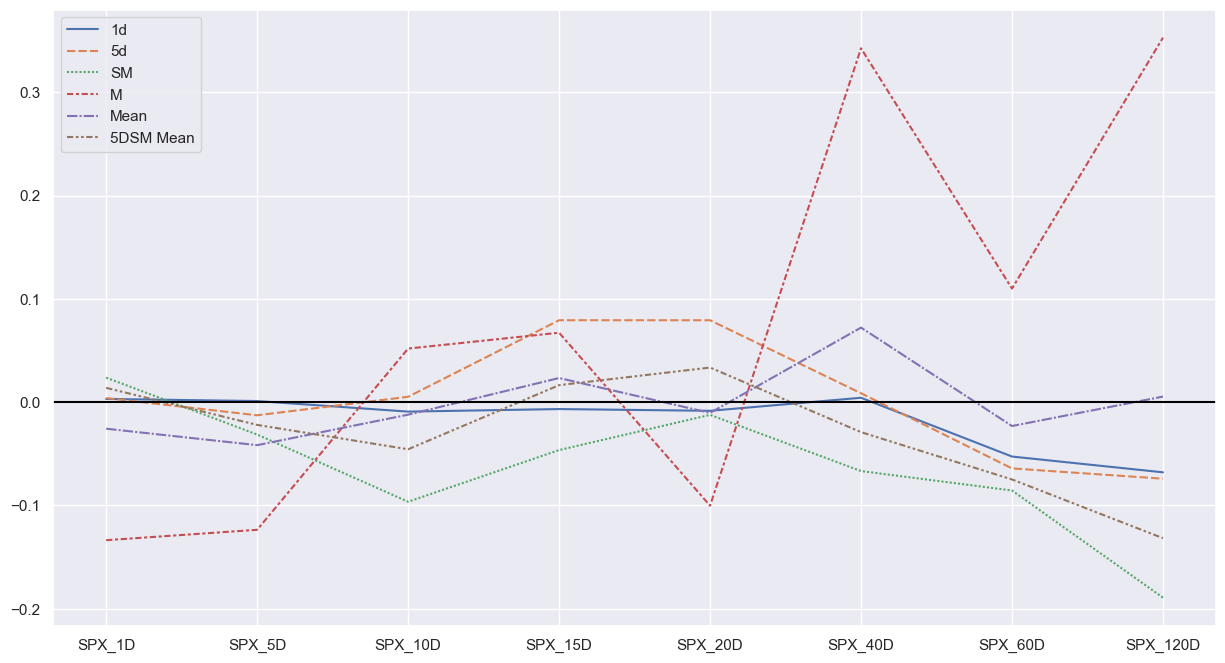

In [4]:
import seaborn as sns

sns.set(rc = {'figure.figsize':(15,8)})
graph = sns.lineplot(data=preds)
graph.axhline(0, c='black')